In [ ]:
!!pip install litellm

# Important!!!
#
# <---- Set your 'OPENAI_API_KEY' as a secret over there with the "key" icon
#
# <---- You will also likely want to use the "folder" icon to add some files
#       for the agent to look at
#
import os
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = api_key

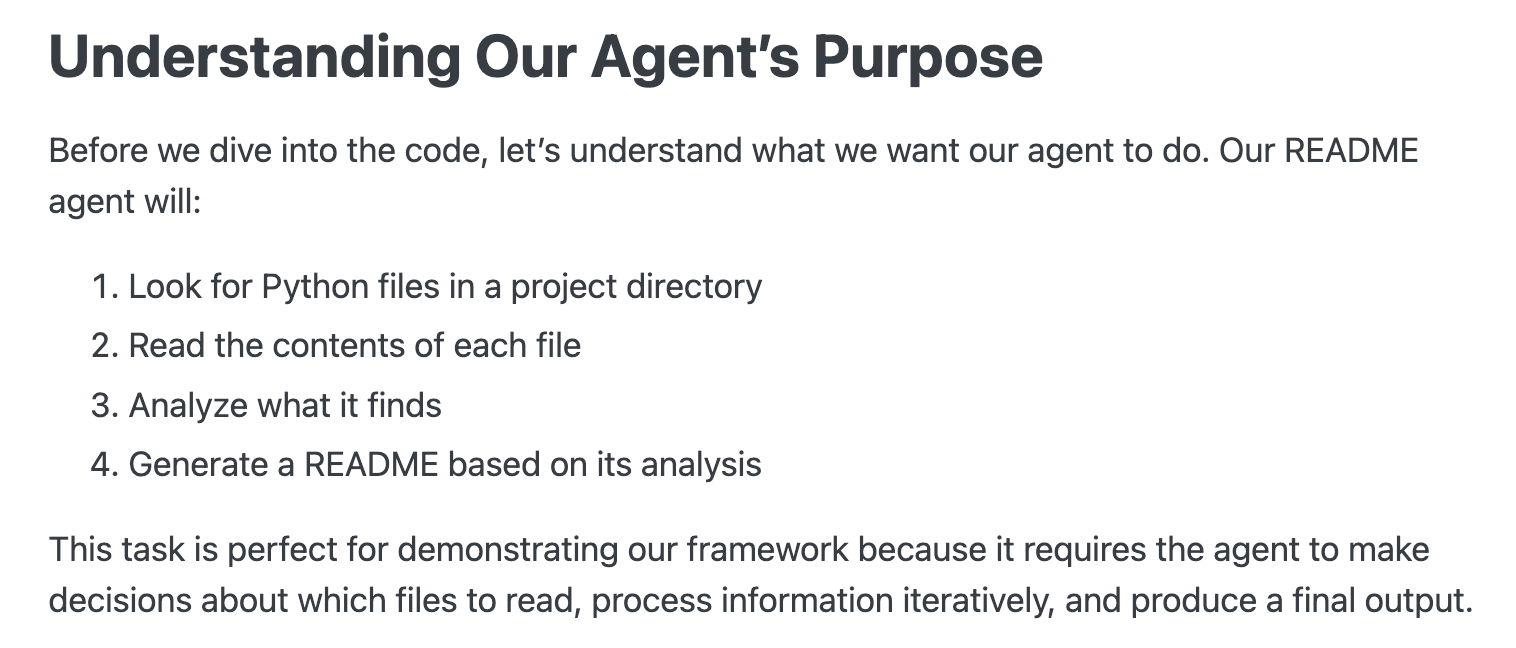

In [ ]:
import json
import time
import traceback
import inspect
from litellm import completion
from dataclasses import dataclass, field
from typing import get_type_hints, List, Callable, Dict, Any

tools = {}
tools_by_tag = {}


def to_openai_tools(tools_metadata: List[dict]):
    openai_tools = [
        {
            "type": "function",
            "function": {
                "name": t['tool_name'],
                # Include up to 1024 characters of the description
                "description": t.get('description',"")[:1024],
                "parameters": t.get('parameters',{}),
            },
        } for t in tools_metadata
    ]
    return openai_tools

# This helper function performs introspection on the decorated function to automatically extract the metadata needed to describe the tool to the agent
def get_tool_metadata(func, tool_name=None, description=None, parameters_override=None, terminal=False, tags=None):
    """
    Extracts metadata for a function to use in tool registration.

    Parameters:
        func (function): The function to extract metadata from.
        tool_name (str, optional): The name of the tool. Defaults to the function name.
        description (str, optional): Description of the tool. Defaults to the function's docstring.
        parameters_override (dict, optional): Override for the argument schema. Defaults to dynamically inferred schema.
        terminal (bool, optional): Whether the tool is terminal. Defaults to False.
        tags (List[str], optional): List of tags to associate with the tool.

    Returns:
        dict: A dictionary containing metadata about the tool, including description, args schema, and the function.
    """
    # Default tool_name to the function name if not provided
    tool_name = tool_name or func.__name__

    # Default description to the function's docstring if not provided
    description = description or (func.__doc__.strip() if func.__doc__ else "No description provided.")

    # Discover the function's signature and type hints if no args_override is provided
    if parameters_override is None:
        signature = inspect.signature(func)
        type_hints = get_type_hints(func)

        # Build the arguments schema dynamically
        args_schema = {
            "type": "object",
            "properties": {},
            "required": []
        }
        for param_name, param in signature.parameters.items():

            if param_name in ["action_context", "action_agent"]:
                continue  # Skip these parameters

            def get_json_type(param_type):
                if param_type == str:
                    return "string"
                elif param_type == int:
                    return "integer"
                elif param_type == float:
                    return "number"
                elif param_type == bool:
                    return "boolean"
                elif param_type == list:
                    return "array"
                elif param_type == dict:
                    return "object"
                else:
                    return "string"

            # Add parameter details
            param_type = type_hints.get(param_name, str)  # Default to string if type is not annotated
            param_schema = {"type": get_json_type(param_type)}  # Convert Python types to JSON schema types

            args_schema["properties"][param_name] = param_schema

            # Add to required if not defaulted
            if param.default == inspect.Parameter.empty:
                args_schema["required"].append(param_name)
    else:
        args_schema = parameters_override

    # Return the metadata as a dictionary
    return {
        "tool_name": tool_name,
        "description": description,
        "parameters": args_schema,
        "function": func,
        "terminal": terminal,
        "tags": tags or []
    }

# we can use Python’s decorator system to automatically extract and maintain this Tools information.
# Our decorator examines the function and automatically:
# 1. Uses the function name as the tool name
# 2. Extracts the docstring for the description
# 3. Analyzes type hints and parameters to build the schema
# 4. Registers the tool in a central registry
# This register_tool decorator is designed to transform regular Python functions into callable tools for an agent system.
def register_tool(tool_name=None, description=None, parameters_override=None, terminal=False, tags=None):
    """
    A decorator to dynamically register a function in the tools dictionary with its parameters, schema, and docstring.

    Parameters:
        tool_name (str, optional): The name of the tool to register. Defaults to the function name.
        description (str, optional): Override for the tool's description. Defaults to the function's docstring.
        parameters_override (dict, optional): Override for the argument schema. Defaults to dynamically inferred schema.
        terminal (bool, optional): Whether the tool is terminal. Defaults to False.
        tags (List[str], optional): List of tags to associate with the tool.

    Returns:
        function: The wrapped function.
    """
    def decorator(func):
        # Use the reusable function to extract metadata
        metadata = get_tool_metadata(
            func=func,
            tool_name=tool_name,
            description=description,
            parameters_override=parameters_override,
            terminal=terminal,
            tags=tags
        )

        # Register the tool in the global dictionary
        tools[metadata["tool_name"]] = {
            "description": metadata["description"],
            "parameters": metadata["parameters"],
            "function": metadata["function"],
            "terminal": metadata["terminal"],
            "tags": metadata["tags"] or []
        }

        for tag in metadata["tags"]:
            if tag not in tools_by_tag:
                tools_by_tag[tag] = []
            tools_by_tag[tag].append(metadata["tool_name"])

        return func
    return decorator


@dataclass
class Prompt:
    messages: List[Dict] = field(default_factory=list)
    tools: List[Dict] = field(default_factory=list)
    metadata: dict = field(default_factory=dict)  # Fixing mutable default issue


def generate_response(prompt: Prompt) -> str:
    """Call LLM to get response"""

    messages = prompt.messages
    tools = prompt.tools

    result = None

    if not tools:
        response = completion(
            model="openai/gpt-4o",
            messages=messages,
            max_tokens=1024
        )
        result = response.choices[0].message.content
    else:
        response = completion(
            model="openai/gpt-4o",
            messages=messages,
            tools=tools,
            max_tokens=1024
        )

        if response.choices[0].message.tool_calls:
            tool = response.choices[0].message.tool_calls[0]
            result = {
                "tool": tool.function.name,
                "args": json.loads(tool.function.arguments),
            }
            result = json.dumps(result)
        else:
            result = response.choices[0].message.content


    return result


@dataclass(frozen=True)
class Goal:
    priority: int
    name: str
    description: str


class Action:
    def __init__(self,
                 name: str,
                 function: Callable,
                 description: str,
                 parameters: Dict,
                 terminal: bool = False):
        self.name = name
        self.function = function
        self.description = description
        self.terminal = terminal
        self.parameters = parameters

    def execute(self, **args) -> Any:
        """Execute the action's function"""
        return self.function(**args)


class ActionRegistry:
    def __init__(self):
        self.actions = {}

    def register(self, action: Action):
        self.actions[action.name] = action

    def get_action(self, name: str) -> [Action, None]:
        return self.actions.get(name, None)

    def get_actions(self) -> List[Action]:
        """Get all registered actions"""
        return list(self.actions.values())


class Memory:
    def __init__(self):
        self.items = []  # Basic conversation histor

    def add_memory(self, memory: dict):
        """Add memory to working memory"""
        self.items.append(memory)

    def get_memories(self, limit: int = None) -> List[Dict]:
        """Get formatted conversation history for prompt"""
        return self.items[:limit]

    def copy_without_system_memories(self):
        """Return a copy of the memory without system memories"""
        filtered_items = [m for m in self.items if m["type"] != "system"]
        memory = Memory()
        memory.items = filtered_items
        return memory


class Environment:
    def execute_action(self, action: Action, args: dict) -> dict:
        """Execute an action and return the result."""
        try:
            result = action.execute(**args)
            return self.format_result(result)
        except Exception as e:
            return {
                "tool_executed": False,
                "error": str(e),
                "traceback": traceback.format_exc()
            }

    def format_result(self, result: Any) -> dict:
        """Format the result with metadata."""
        return {
            "tool_executed": True,
            "result": result,
            "timestamp": time.strftime("%Y-%m-%dT%H:%M:%S%z")
        }


class AgentLanguage:
    def __init__(self):
        pass

    def construct_prompt(self,
                         actions: List[Action],
                         environment: Environment,
                         goals: List[Goal],
                         memory: Memory) -> Prompt:
        raise NotImplementedError("Subclasses must implement this method")


    def parse_response(self, response: str) -> dict:
        raise NotImplementedError("Subclasses must implement this method")



class AgentFunctionCallingActionLanguage(AgentLanguage):

    def __init__(self):
        super().__init__()

    def format_goals(self, goals: List[Goal]) -> List:
        # Map all goals to a single string that concatenates their description
        # and combine into a single message of type system
        sep = "\n-------------------\n"
        goal_instructions = "\n\n".join([f"{goal.name}:{sep}{goal.description}{sep}" for goal in goals])
        return [
            {"role": "system", "content": goal_instructions}
        ]

    def format_memory(self, memory: Memory) -> List:
        """Generate response from language model"""
        # Map all environment results to a role:user messages
        # Map all assistant messages to a role:assistant messages
        # Map all user messages to a role:user messages
        items = memory.get_memories()
        mapped_items = []
        for item in items:

            content = item.get("content", None)
            if not content:
                content = json.dumps(item, indent=4)

            if item["type"] == "assistant":
                mapped_items.append({"role": "assistant", "content": content})
            elif item["type"] == "environment":
                mapped_items.append({"role": "assistant", "content": content})
            else:
                mapped_items.append({"role": "user", "content": content})

        return mapped_items

    def format_actions(self, actions: List[Action]) -> [List,List]:
        """Generate response from language model"""

        tools = [
            {
                "type": "function",
                "function": {
                    "name": action.name,
                    # Include up to 1024 characters of the description
                    "description": action.description[:1024],
                    "parameters": action.parameters,
                },
            } for action in actions
        ]

        return tools

    def construct_prompt(self,
                         actions: List[Action],
                         environment: Environment,
                         goals: List[Goal],
                         memory: Memory) -> Prompt:

        prompt = []
        prompt += self.format_goals(goals)
        prompt += self.format_memory(memory)

        tools = self.format_actions(actions)

        return Prompt(messages=prompt, tools=tools)

    def adapt_prompt_after_parsing_error(self,
                                         prompt: Prompt,
                                         response: str,
                                         traceback: str,
                                         error: Any,
                                         retries_left: int) -> Prompt:

        return prompt

    def parse_response(self, response: str) -> dict:
        """Parse LLM response into structured format by extracting the ```json block"""

        try:
            return json.loads(response)

        except Exception as e:
            return {
                "tool": "terminate",
                "args": {"message":response}
            }



class PythonActionRegistry(ActionRegistry):
    def __init__(self, tags: List[str] = None, tool_names: List[str] = None):
        super().__init__()

        self.terminate_tool = None

        for tool_name, tool_desc in tools.items():
            if tool_name == "terminate":
                self.terminate_tool = tool_desc

            if tool_names and tool_name not in tool_names:
                continue

            tool_tags = tool_desc.get("tags", [])
            if tags and not any(tag in tool_tags for tag in tags):
                continue

            self.register(Action(
                name=tool_name,
                function=tool_desc["function"],
                description=tool_desc["description"],
                parameters=tool_desc.get("parameters", {}),
                terminal=tool_desc.get("terminal", False)
            ))

    def register_terminate_tool(self):
        if self.terminate_tool:
            self.register(Action(
                name="terminate",
                function=self.terminate_tool["function"],
                description=self.terminate_tool["description"],
                parameters=self.terminate_tool.get("parameters", {}),
                terminal=self.terminate_tool.get("terminal", False)
            ))
        else:
            raise Exception("Terminate tool not found in tool registry")



class Agent:
    def __init__(self,
                 goals: List[Goal],
                 agent_language: AgentLanguage,
                 action_registry: ActionRegistry,
                 generate_response: Callable[[Prompt], str],
                 environment: Environment):
        """
        Initialize an agent with its core GAME components
        """
        self.goals = goals
        self.generate_response = generate_response
        self.agent_language = agent_language
        self.actions = action_registry
        self.environment = environment

    def construct_prompt(self, goals: List[Goal], memory: Memory, actions: ActionRegistry) -> Prompt:
        """Build prompt with memory context"""
        return self.agent_language.construct_prompt(
            actions=actions.get_actions(),
            environment=self.environment,
            goals=goals,
            memory=memory
        )

    def get_action(self, response):
        invocation = self.agent_language.parse_response(response)
        action = self.actions.get_action(invocation["tool"])
        return action, invocation

    def should_terminate(self, response: str) -> bool:
        action_def, _ = self.get_action(response)
        return action_def.terminal

    def set_current_task(self, memory: Memory, task: str):
        memory.add_memory({"type": "user", "content": task})

    def update_memory(self, memory: Memory, response: str, result: dict):
        """
        Update memory with the agent's decision and the environment's response.
        """
        new_memories = [
            {"type": "assistant", "content": response},
            {"type": "environment", "content": json.dumps(result)}
        ]
        for m in new_memories:
            memory.add_memory(m)

    def prompt_llm_for_action(self, full_prompt: Prompt) -> str:
        response = self.generate_response(full_prompt)
        return response

    def run(self, user_input: str, memory=None, max_iterations: int = 50) -> Memory:
        """
        Execute the GAME loop for this agent with a maximum iteration limit.
        """
        memory = memory or Memory()
        self.set_current_task(memory, user_input)

        for _ in range(max_iterations):
            # Construct a prompt that includes the Goals, Actions, and the current Memory
            prompt = self.construct_prompt(self.goals, memory, self.actions)

            print("Agent thinking...")
            # Generate a response from the agent
            response = self.prompt_llm_for_action(prompt)
            print(f"Agent Decision: {response}")

            # Determine which action the agent wants to execute
            action, invocation = self.get_action(response)

            # Execute the action in the environment
            result = self.environment.execute_action(action, invocation["args"])
            print(f"Action Result: {result}")

            # Update the agent's memory with information about what happened
            self.update_memory(memory, response, result)

            # Check if the agent has decided to terminate
            if self.should_terminate(response):
                break

        return memory


In [ ]:

    # First, we'll define our tools using decorators
    # we use our decorator to tag tools based on their purpose
    @register_tool(tags=["file_operations", "read"])
    def read_project_file(name: str) -> str:
        """Reads and returns the content of a specified project file.

        Opens the file in read mode and returns its entire contents as a string.
        Raises FileNotFoundError if the file doesn't exist.

        Args:
            name: The name of the file to read

        Returns:
            The contents of the file as a string
        """
        with open(name, "r") as f:
            return f.read()

    @register_tool(tags=["file_operations", "list"])
    def list_project_files() -> List[str]:
        """Lists all Python files in the current project directory.

        Scans the current directory and returns a sorted list of all files
        that end with '.py'.

        Returns:
            A sorted list of Python filenames
        """
        return sorted([file for file in os.listdir(".")
                      if file.endswith(".py")])

    @register_tool(tags=["system"], terminal=True)
    def terminate(message: str) -> str:
        """Terminates the agent's execution with a final message.

        Args:
            message: The final message to return before terminating

        Returns:
            The message with a termination note appended
        """
        return f"{message}\nTerminating..."


    # Define the agent's goals
    goals = [
        Goal(priority=1,
              name="Gather Information",
              description="Read each file in the project in order to build a deep understanding of the project in order to write a README"),
        Goal(priority=1,
              name="Terminate",
              description="Call terminate when done and provide a complete README for the project in the message parameter")
    ]

    # Create an agent instance with tag-filtered actions
    agent = Agent(
        goals=goals,
        agent_language=AgentFunctionCallingActionLanguage(),
        # The ActionRegistry now automatically loads tools with these tags
        action_registry=PythonActionRegistry(tags=["file_operations", "system"]),
        generate_response=generate_response,
        environment=Environment()
    )

    # Run the agent with user input
    user_input = "Write a README for this project."
    final_memory = agent.run(user_input)
    print(final_memory.get_memories())

Agent thinking...
Agent Decision: {"tool": "list_project_files", "args": {}}
Action Result: {'tool_executed': True, 'result': [], 'timestamp': '2025-03-10T21:02:37+0000'}
Agent thinking...
Agent Decision: {"tool": "terminate", "args": {"message": "# ReadMe for Project\n\n## Introduction\nThis project is meant to be an illustrative placeholder for demonstrating file operations within a project directory. The project structure is minimal, and as of now, does not contain any Python files or any code files.\n\n## Project Structure\nAs there are no Python files in the directory, the project does not currently contain any functionality or script to run.\n\n## Future Enhancements\n- Add Python scripts to demonstrate specific functionalities.\n- Include modules with functions and classes.\n- Implement a core business logic module.\n\n## How to Contribute\nThis project currently lacks content; contributions are essential for shaping the project into something useful. Here's how you can contribu